In [ ]:
#!pip install /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedGroupKFold,GroupKFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os
import pickle
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# train = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
# test = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/test.csv')

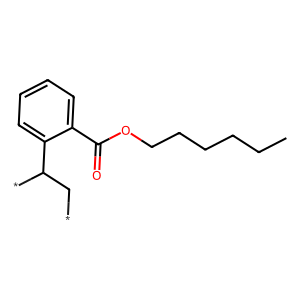

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles(train['SMILES'][0])
Draw.MolToImage(mol)

In [4]:
train.shape

(7973, 7)

In [5]:
train.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [6]:
train.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [7]:
train.describe(include="all")

,id,SMILES,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,7973,511.000000,7030.000000,737.000000,613.000000,614.000000
unique,NaN,7973,NaN,NaN,NaN,NaN,NaN
top,NaN,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN
mean,1.080050e+09,NaN,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,NaN,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,NaN,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,NaN,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,NaN,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,NaN,161.147595,0.380790,0.330500,1.062096,20.411067


In [8]:
missing = train.isnull().sum()[['Tg', 'FFV', 'Tc', 'Density', 'Rg']]
missing

Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

### Getting features from rdkit

In [9]:
def compute_rdkit_feats(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {}
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    
    for i in range(1, maccs.GetNumBits()):  # bit 0 is always 1
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))

    # Descriptors
    descs = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
        'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
        'NumRings': Descriptors.RingCount(mol),
        'NumRotatableBonds': CalcNumRotatableBonds(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'MolMR': Descriptors.MolMR(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }
    features.update(descs)

    return features

In [10]:
maccs_data = []

for smile in tqdm(train['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data.append(None)
    else:
        maccs_data.append(feats)
        
maccs_df = pd.DataFrame(maccs_data)
train_rdkit = pd.concat([train, maccs_df], axis=1)

  0%|          | 0/7973 [00:00<?, ?it/s]

In [11]:
train_rdkit.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg,MACCS_1,MACCS_2,MACCS_3,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,0,0,0,...,232.323,26.30,92,17,1,8,3.98170,68.4145,2,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,0,0,0,...,598.919,24.06,236,45,5,16,12.35960,193.3954,2,2
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,0,0,0,...,1003.207,122.27,364,73,10,15,14.21700,281.6006,9,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,0,0,0,...,542.726,24.06,204,42,6,7,11.00768,179.8154,2,2
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,0,0,0,...,965.154,182.28,376,70,6,34,11.84500,266.9958,14,0


### Train baseline model

#### Make DataSet

In [12]:
class NeuRIPSDataset(Dataset):
    def __init__(self, df, feat_cols, target):
        self.X = df[feat_cols].values.astype('float32')
        self.y = df[target].values.astype('float32')
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

### Define the model

In [13]:
class NeurIPSNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64,1)
        )
        self._initialize_weights()
        
    def forward(self, x):
        return self.net(x).squeeze(1) # output shape: (B,)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [14]:
rdkit_cols = train_rdkit.columns.tolist()[7:]
targets = train_rdkit.columns.tolist()[2:7]

### Write train and validation functions

In [15]:
def train(model, dl, loss_fn, opt):
    model.train()
    total_loss = 0
    #n = 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        n += len(xb)
        total_loss += loss.item() * len(xb)
    #return total_loss / n
    return total_loss / len(loader.dataset)

def validate(model, dl, loss_fn):
    model.eval()
    total_loss = 0
    all_preds, all_trues = [], []
    n = 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        n += len(xb)
        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(yb.detach().cpu().numpy())
        total_loss += loss.item() * len(xb)
    return total_loss / n, np.array(all_preds), np.array(all_trues)

### Set-up Hooks logic

In [16]:
activation_stats = {}
activation_histograms = {}

def get_activation_stats(name):
    def hook(model, input, output):
        data = output.detach().cpu().numpy().flatten()
        activation_stats[name] = {
            "mean": data.mean(),
            "std": data.std()
        }
        activation_histograms[name] = data
    return hook

In [30]:
def train_all(device, epochs, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    preds, maes, true_vals, ranges = {}, {}, {}, {}
    
    
    for target in targets:
        print(f'training model for {target}')
        df_nn = train_rdkit[rdkit_cols + [target]].dropna()
        scaler = StandardScaler()

        df_nn[rdkit_cols] = scaler.fit_transform(df_nn[rdkit_cols])
        
        with open(os.path.join(save_dir, f'{target}_scaler.pkl'), 'wb') as f:
            pickle.dump(scaler, f)

        train_df, val_df = train_test_split(df_nn, test_size=0.2, random_state=42)

        train_ds = NeuRIPSDataset(train_df, rdkit_cols, target)
        val_ds = NeuRIPSDataset(val_df, rdkit_cols, target)

        train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

        model = NeurIPSNet(input_dim=len(rdkit_cols)).to(device)
        loss_fn = nn.L1Loss()
        optimizer = Adam(model.parameters(), lr=1e-3)

        for name, module in model.named_modules():
            if isinstance(module, (nn.Linear, nn.ReLU, nn.BatchNorm1d)):
                module.register_forward_hook(get_activation_stats(f'{target}_{name}'))

        for epoch in range(epochs):
            train_loss = train(model, train_dl, loss_fn, optimizer)
            val_loss, model_preds, trues = validate(model, val_dl, loss_fn)
            print(f"Epoch {epoch}: Train MAE = {train_loss:.4f}, Val MAE = {val_loss:.4f}")
            
        # save model
        torch.save(model.state_dict(), os.path.join(save_dir, f'{target}_model.pt'))

        preds[target] = model_preds
        true_vals[target] = trues
        maes[target] = mean_absolute_error(model_preds, trues)
        ranges[target] = trues.max() - trues.min()

        for layer_name, data in activation_histograms.items():
                if layer_name.startswith(target):
                    plt.figure()
                    plt.hist(data, bins=50, alpha=0.75, color='steelblue')
                    plt.title(f"{layer_name} Activation Histogram")
                    plt.xlabel("Activation Value")
                    plt.ylabel("Frequency")
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
                    
    return preds, true_vals, maes, ranges

In [49]:
def predict_test(test_df, model_dir='saved_models'):
    preds = {}
    
    for target in targets:
        with open(os.path.join(model_dir, f"{target}_scaler.pkl"), 'rb') as f:
            scaler = pickle.load(f)
            
        test_df_scaled = test_df.copy()
        test_df_scaled[rdkit_cols] = scaler.transform(test_df_scaled[rdkit_cols])
        X_test = torch.tensor(test_df_scaled[rdkit_cols].values.astype('float32'))
        
        model = NeurIPSNet(input_dim = len(rdkit_cols)).to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, f"{target}_model.pt")))
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test.to(device)).cpu().numpy()
            preds[target] = y_pred

    return pd.concat([test_df['id'], pd.DataFrame(preds)], axis=1)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

training model for Tg
Epoch 0: Train MAE = 111.8871, Val MAE = 100.0475
Epoch 1: Train MAE = 111.3754, Val MAE = 99.4093
Epoch 2: Train MAE = 110.9700, Val MAE = 98.8262
Epoch 3: Train MAE = 110.5980, Val MAE = 98.0382
Epoch 4: Train MAE = 110.2504, Val MAE = 97.3257
Epoch 5: Train MAE = 109.9325, Val MAE = 96.7017
Epoch 6: Train MAE = 109.6623, Val MAE = 95.9196
Epoch 7: Train MAE = 109.2488, Val MAE = 95.5128
Epoch 8: Train MAE = 108.8669, Val MAE = 94.9180
Epoch 9: Train MAE = 108.5336, Val MAE = 94.2998
Epoch 10: Train MAE = 108.1177, Val MAE = 93.8270
Epoch 11: Train MAE = 107.8688, Val MAE = 93.2953
Epoch 12: Train MAE = 107.5191, Val MAE = 92.7352
Epoch 13: Train MAE = 107.1451, Val MAE = 92.0063
Epoch 14: Train MAE = 106.7677, Val MAE = 91.3431
Epoch 15: Train MAE = 106.4466, Val MAE = 90.6494
Epoch 16: Train MAE = 106.0713, Val MAE = 90.2655
Epoch 17: Train MAE = 105.7891, Val MAE = 89.3024
Epoch 18: Train MAE = 105.4394, Val MAE = 88.5937
Epoch 19: Train MAE = 104.9993, Val M

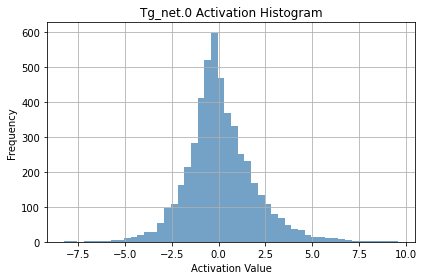

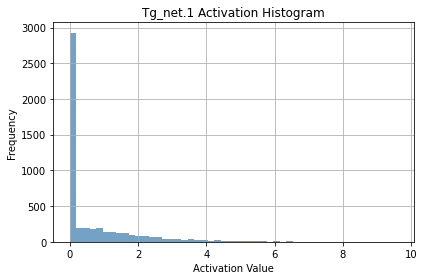

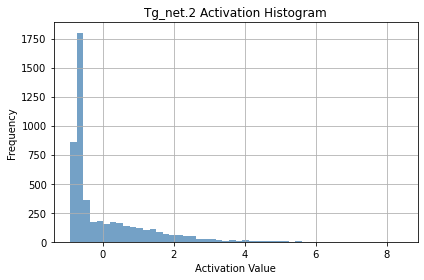

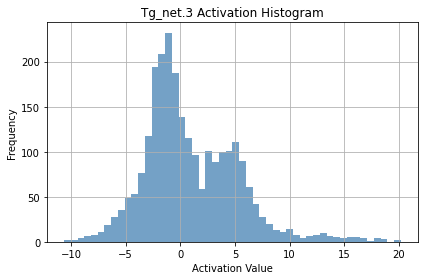

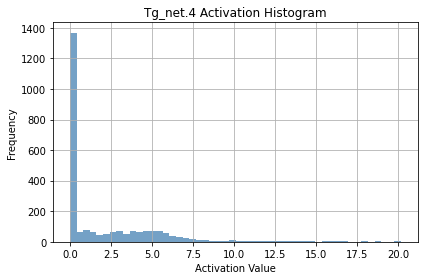

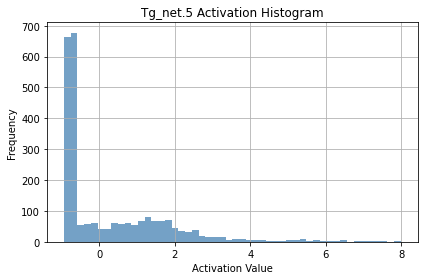

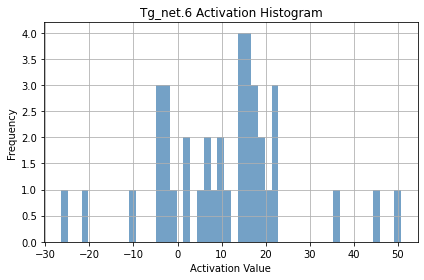

training model for FFV
Epoch 0: Train MAE = 0.5145, Val MAE = 0.2560
Epoch 1: Train MAE = 0.2668, Val MAE = 0.1652
Epoch 2: Train MAE = 0.1827, Val MAE = 0.1261
Epoch 3: Train MAE = 0.1574, Val MAE = 0.1053
Epoch 4: Train MAE = 0.1519, Val MAE = 0.0745
Epoch 5: Train MAE = 0.1006, Val MAE = 0.0610
Epoch 6: Train MAE = 0.0917, Val MAE = 0.0543
Epoch 7: Train MAE = 0.0952, Val MAE = 0.0440
Epoch 8: Train MAE = 0.0673, Val MAE = 0.0407
Epoch 9: Train MAE = 0.0823, Val MAE = 0.0362
Epoch 10: Train MAE = 0.0754, Val MAE = 0.0365
Epoch 11: Train MAE = 0.0648, Val MAE = 0.0376
Epoch 12: Train MAE = 0.0932, Val MAE = 0.0313
Epoch 13: Train MAE = 0.0569, Val MAE = 0.0293
Epoch 14: Train MAE = 0.0661, Val MAE = 0.0297
Epoch 15: Train MAE = 0.0571, Val MAE = 0.0268
Epoch 16: Train MAE = 0.0406, Val MAE = 0.0257
Epoch 17: Train MAE = 0.0514, Val MAE = 0.0339
Epoch 18: Train MAE = 0.0905, Val MAE = 0.0544
Epoch 19: Train MAE = 0.1281, Val MAE = 0.0525


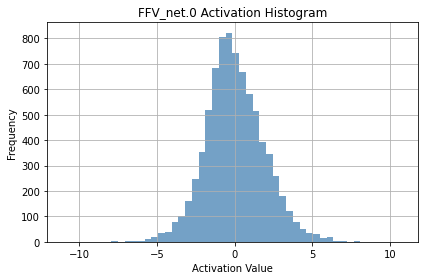

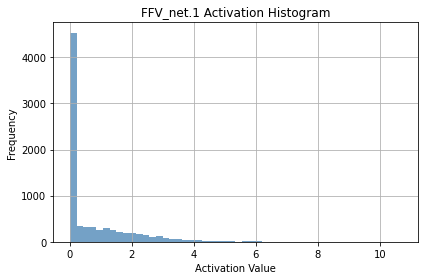

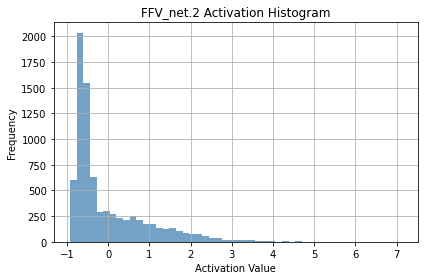

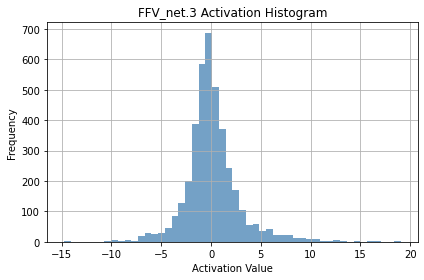

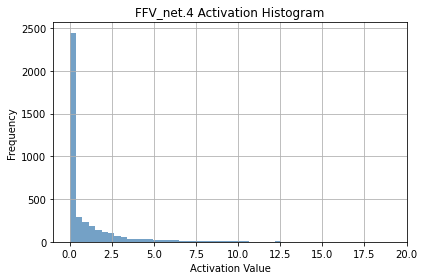

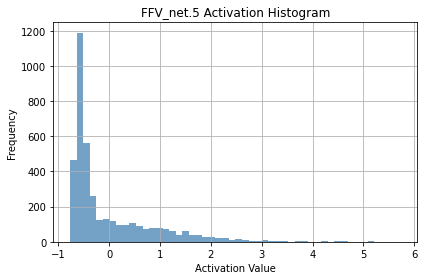

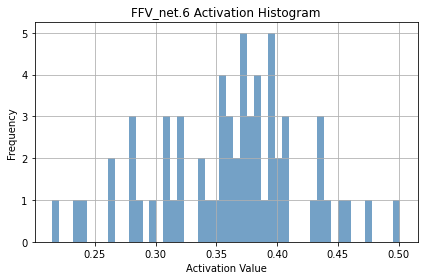

training model for Tc
Epoch 0: Train MAE = 0.7502, Val MAE = 0.4773
Epoch 1: Train MAE = 0.4703, Val MAE = 0.3222
Epoch 2: Train MAE = 0.3532, Val MAE = 0.2820
Epoch 3: Train MAE = 0.3008, Val MAE = 0.2097
Epoch 4: Train MAE = 0.2860, Val MAE = 0.1655
Epoch 5: Train MAE = 0.2472, Val MAE = 0.1596
Epoch 6: Train MAE = 0.2357, Val MAE = 0.1815
Epoch 7: Train MAE = 0.2444, Val MAE = 0.1669
Epoch 8: Train MAE = 0.2287, Val MAE = 0.1363
Epoch 9: Train MAE = 0.2160, Val MAE = 0.1749
Epoch 10: Train MAE = 0.2023, Val MAE = 0.1430
Epoch 11: Train MAE = 0.1877, Val MAE = 0.1871
Epoch 12: Train MAE = 0.1864, Val MAE = 0.1181
Epoch 13: Train MAE = 0.1742, Val MAE = 0.1331
Epoch 14: Train MAE = 0.1836, Val MAE = 0.0959
Epoch 15: Train MAE = 0.1805, Val MAE = 0.1479
Epoch 16: Train MAE = 0.1759, Val MAE = 0.1540
Epoch 17: Train MAE = 0.1767, Val MAE = 0.1653
Epoch 18: Train MAE = 0.1696, Val MAE = 0.1759
Epoch 19: Train MAE = 0.1634, Val MAE = 0.1187


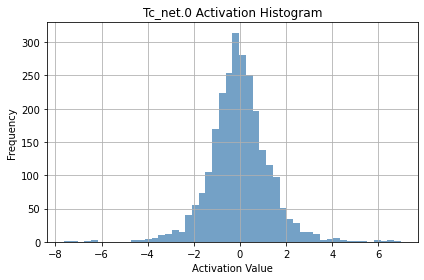

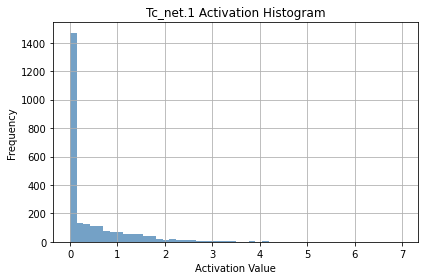

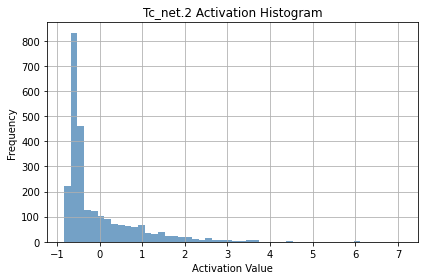

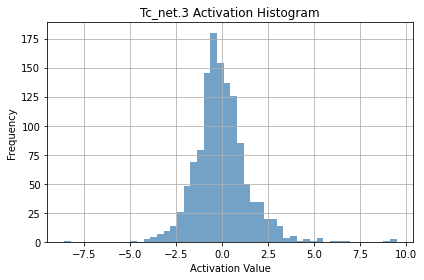

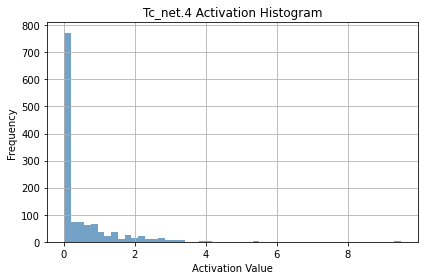

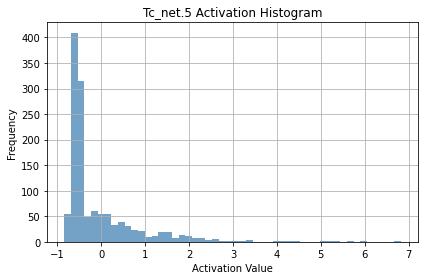

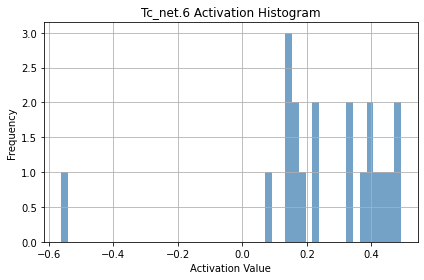

training model for Density
Epoch 0: Train MAE = 1.2246, Val MAE = 0.9440
Epoch 1: Train MAE = 0.9621, Val MAE = 0.6483
Epoch 2: Train MAE = 0.8566, Val MAE = 0.5259
Epoch 3: Train MAE = 0.7853, Val MAE = 0.3501
Epoch 4: Train MAE = 0.7028, Val MAE = 0.3421
Epoch 5: Train MAE = 0.6540, Val MAE = 0.4166
Epoch 6: Train MAE = 0.5757, Val MAE = 0.3688
Epoch 7: Train MAE = 0.4856, Val MAE = 0.2126
Epoch 8: Train MAE = 0.4105, Val MAE = 0.2225
Epoch 9: Train MAE = 0.3541, Val MAE = 0.1874
Epoch 10: Train MAE = 0.3100, Val MAE = 0.1580
Epoch 11: Train MAE = 0.3253, Val MAE = 0.1548
Epoch 12: Train MAE = 0.2499, Val MAE = 0.2219
Epoch 13: Train MAE = 0.2690, Val MAE = 0.1860
Epoch 14: Train MAE = 0.2548, Val MAE = 0.1768
Epoch 15: Train MAE = 0.2488, Val MAE = 0.1737
Epoch 16: Train MAE = 0.2037, Val MAE = 0.1679
Epoch 17: Train MAE = 0.2184, Val MAE = 0.1975
Epoch 18: Train MAE = 0.2036, Val MAE = 0.2019
Epoch 19: Train MAE = 0.2089, Val MAE = 0.1454


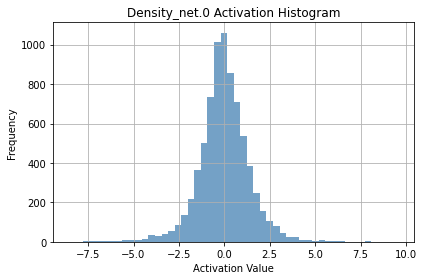

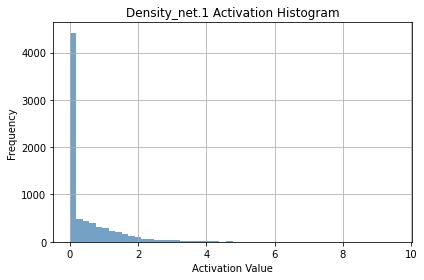

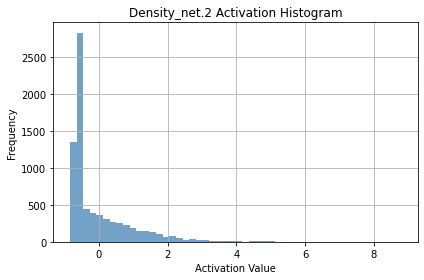

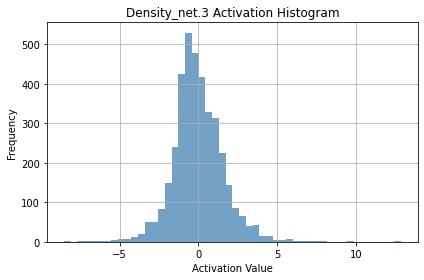

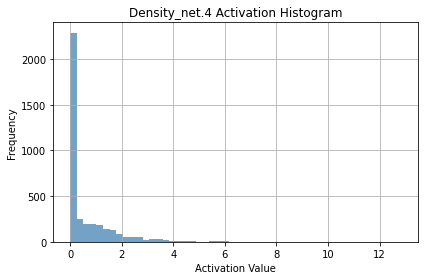

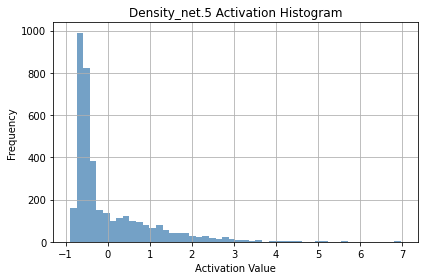

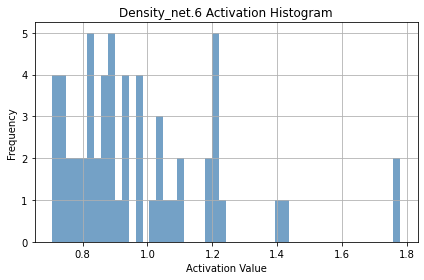

training model for Rg
Epoch 0: Train MAE = 16.3121, Val MAE = 17.0337
Epoch 1: Train MAE = 16.2270, Val MAE = 15.9286
Epoch 2: Train MAE = 16.1444, Val MAE = 15.0916
Epoch 3: Train MAE = 16.0585, Val MAE = 14.3426
Epoch 4: Train MAE = 15.9676, Val MAE = 13.6797
Epoch 5: Train MAE = 15.8707, Val MAE = 13.1952
Epoch 6: Train MAE = 15.7674, Val MAE = 12.6799
Epoch 7: Train MAE = 15.6568, Val MAE = 12.1643
Epoch 8: Train MAE = 15.5383, Val MAE = 11.7887
Epoch 9: Train MAE = 15.4110, Val MAE = 11.2765
Epoch 10: Train MAE = 15.2747, Val MAE = 10.8375
Epoch 11: Train MAE = 15.1304, Val MAE = 10.3263
Epoch 12: Train MAE = 14.9819, Val MAE = 9.8607
Epoch 13: Train MAE = 14.8133, Val MAE = 9.4217
Epoch 14: Train MAE = 14.6478, Val MAE = 9.0662
Epoch 15: Train MAE = 14.4573, Val MAE = 8.5864
Epoch 16: Train MAE = 14.2667, Val MAE = 8.2610
Epoch 17: Train MAE = 14.0753, Val MAE = 7.7793
Epoch 18: Train MAE = 13.8664, Val MAE = 7.4208
Epoch 19: Train MAE = 13.6394, Val MAE = 7.0956


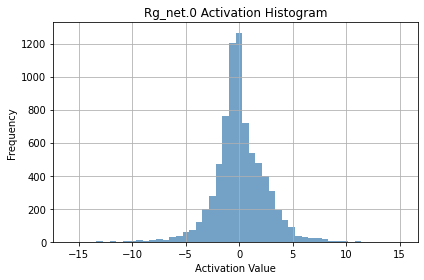

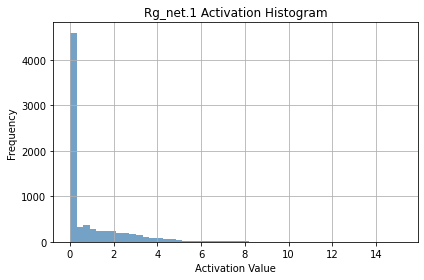

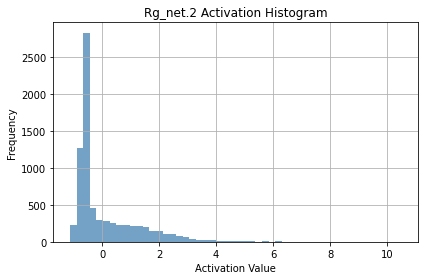

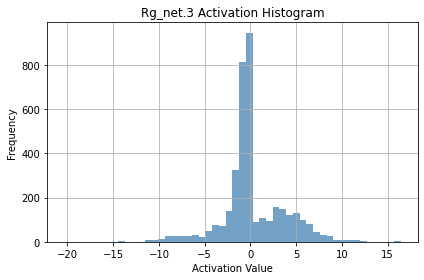

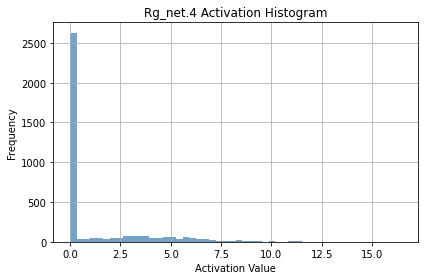

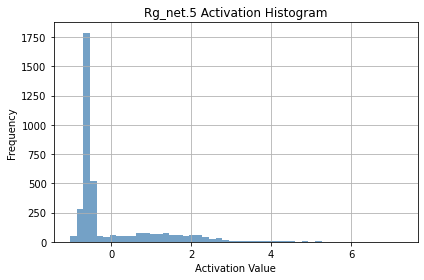

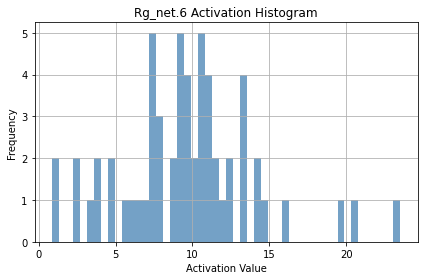

In [33]:
preds, true_vals, maes, ranges = train_all(device, 20)

### Compute competition metric (wMAE)

In [34]:
# Count available samples (n_i) for each target
n_samples = {t: len(true_vals[t]) for t in targets}
K = len(targets)

# compute w_i per target
weights = {}
sqrt_inv = [np.sqrt(1/n_samples[t]) for t in targets]
normalizer = K / sum(sqrt_inv)

for t in targets:
    r_i = ranges[t]
    w_i = (1 / r_i) * (normalizer * np.sqrt(1 / n_samples[t]))
    weights[t] = w_i
    
# final weighted mae
wmae = sum(weights[t] * maes[t] for t in targets)

In [35]:
wmae

1.1084524179683708

In [36]:
print("\n Per-target MAEs:")
for t in targets:
    print(f"{t:<10} MAE: {maes[t]:.4f} | Weight: {weights[t]:.4f}")

print(f"\n Final Weighted MAE (Competition Metric): {wmae:.4f}")



 Per-target MAEs:
Tg         MAE: 87.6655 | Weight: 0.0024
FFV        MAE: 0.0525 | Weight: 0.6375
Tc         MAE: 0.1187 | Weight: 2.4036
Density    MAE: 0.1454 | Weight: 1.6607
Rg         MAE: 7.0956 | Weight: 0.0470

 Final Weighted MAE (Competition Metric): 1.1085


In [37]:
maccs_data_test = []

for smile in tqdm(test['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data_test.append(None)
    else:
        maccs_data_test.append(feats)
        
maccs_df_test = pd.DataFrame(maccs_data_test)
test_rdkit = pd.concat([test, maccs_df_test], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
test_rdkit.head()

,id,SMILES,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,0,0,0,0,0,0,0,0,...,540.463,43.18,198,39,4,8,7.3603,134.182,4,0
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,0,0,0,0,0,0,0,0,...,510.589,52.60,190,39,5,9,7.2845,151.539,4,0
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...,0,0,0,0,0,0,0,0,...,586.644,93.22,220,44,6,13,6.1875,164.728,6,0


In [50]:
submission = predict_test(test_rdkit)

In [51]:
submission

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,-6.015246,0.380098,-0.107909,-1.062412,-10.744074
1,1422188626,21.983036,0.348765,0.348904,0.453505,7.375945
2,2032016830,5.180766,0.407959,0.076726,0.972622,12.591804


In [ ]:
submission_df.to_csv('RandomForest_BaseLine.csv', index=False)